In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet;"'
julia -e 'using Pkg; pkg"build Knet;"'

--2020-03-17 18:08:18--  https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz [following]
--2020-03-17 18:08:18--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95929584 (91M) [application/x-gzip]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================

In [0]:
using Knet
# Test if Knet is using gpu
Knet.gpu()

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1273
┌ Warning: You are using CUDNN 7.6.5 for CUDA 10.1.0 with CUDA toolkit 10.0.130; these might be incompatible.
└ @ CuArrays /root/.julia/packages/CuArrays/A6GUx/src/CuArrays.jl:128


0

In [96]:
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots", "FileIO", "Images", "TestImages","PyCall", "ImageMagick", "Colors", "Random", "IterTools", "Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
Pkg.update("Knet")
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, progress, sgd, dropout, relu, Data, Param, abs
#using ImageView;
using Knet, ImageMagick, Colors, Images, Random, TestImages

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


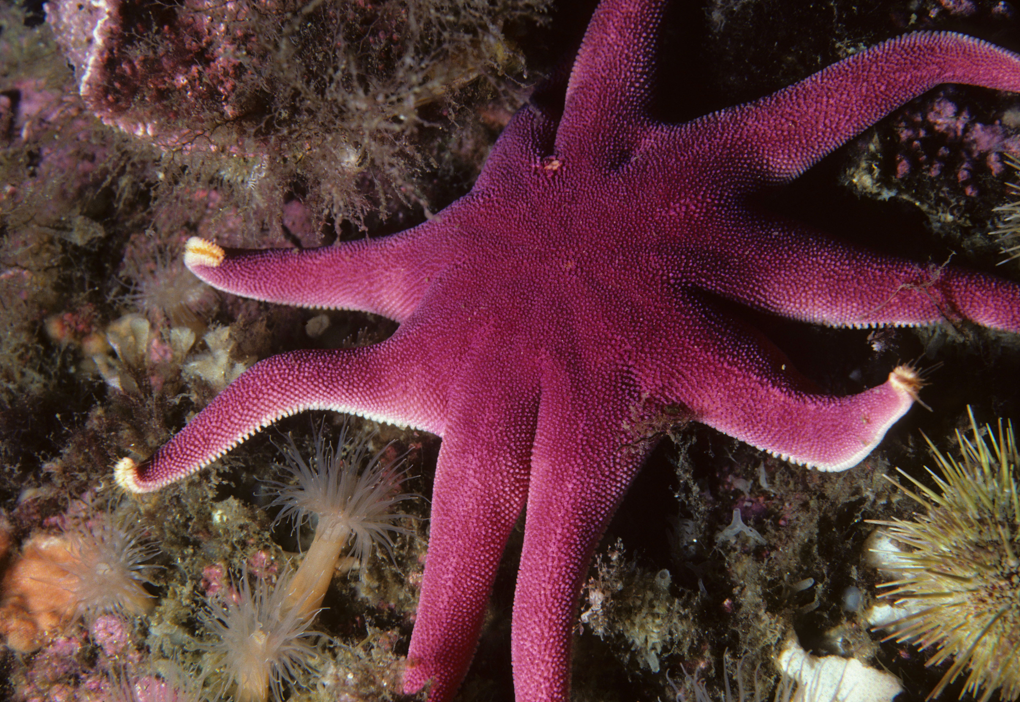

In [116]:
x = load("0001x2.png")

In [4]:
r = KnetArray{Float32}(rand(5, 5, 3, 1))

5×5×3×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.537668  0.258827  0.897275   0.839827  0.839812
 0.220736  0.143891  0.0776524  0.600555  0.550101
 0.397464  0.958974  0.322811   0.287019  0.670492
 0.476182  0.862838  0.580218   0.544513  0.10585 
 0.947138  0.910459  0.326277   0.525773  0.60042 

[:, :, 2, 1] =
 0.954614   0.937241   0.408431  0.367625  0.807332
 0.829622   0.0191228  0.503855  0.298574  0.999393
 0.7125     0.1654     0.819439  0.142096  0.936976
 0.0903811  0.491322   0.873689  0.345263  0.349124
 0.582876   0.0720638  0.46386   0.447915  0.544084

[:, :, 3, 1] =
 0.75388   0.0425638  0.76815    0.835943   0.95428 
 0.782833  0.02827    0.0564757  0.900353   0.600047
 0.165793  0.299999   0.0677122  0.194819   0.735112
 0.167716  0.816938   0.0737771  0.750265   0.369439
 0.910718  0.53365    0.0356212  0.0881029  0.609458

In [0]:
;ls

0010x2.png
sample_data


In [0]:
function get_filenames(dataset_dir::String, dataset_type::String)
    file_names = Array{String}([])
        data = dataset_dir*dataset_type*"/"
        dirs = readdir(data)
        for dir in dirs
            full_dir = data*dir
            if isfile(full_dir)
                push!(file_names, full_dir)
            elseif isdir(full_dir)
                full_dir = full_dir*"/"*first(readdir(full_dir))
                isfile(full_dir) && push!(file_names, full_dir)
            end
        end
    return file_names
end

get_filenames (generic function with 1 method)

In [0]:
train_data_lr= get_filenames("/content/sample_data/", "train_lr_bic_x2")
train_data_hr= get_filenames("/content/sample_data/", "train_hr")
test_data_lr= get_filenames("/content/sample_data/", "test_lr_bic_x2")
test_data_hr= get_filenames("/content/sample_data/", "test_hr")



5-element Array{String,1}:
 "/content/sample_data/test_hr/0801.png"
 "/content/sample_data/test_hr/0802.png"
 "/content/sample_data/test_hr/0803.png"
 "/content/sample_data/test_hr/0804.png"
 "/content/sample_data/test_hr/0805.png"

In [0]:
function minibatch(X, Y, bs=3)
	#takes raw input (X) and gold labels (Y)
	#returns list of minibatches (x, y)
	data = Any[]

	#start of step 1
	for i=1:round(Int,size(X,2)/bs)
		X_el = X[:,(i-1)*bs+1:i*bs]
		Y_el = Y[:,(i-1)*bs+1:i*bs]
		data_el = (X_el,Y_el)
		push!(data,data_el)
	end

	return data
end

minibatch (generic function with 2 methods)

In [0]:
function create_x(x_folder,imsize,n)
	x = zeros(Float32,imsize .^ 2 .* 3,1)
	image_list = readdir(x_folder)
	for i=1:n
		cur_im = load(string(x_folder,image_list[i]))
		cur_im = convert(Array{Float32},channelview(cur_im))
		if ndims(cur_im)==2
      print("yes")
			tmp = zeros(3,size(cur_im,1),size(cur_im,2))
			tmp[1,:,:] = cur_im
			tmp[2,:,:] = cur_im
			tmp[3,:,:] = cur_im
			cur_im = tmp
		end
			cur_im = permutedims(cur_im,[2 3 1])
		# pad zeros to make image square
		if size(cur_im,2) < imsize
			cur_im = hcat(zeros(Float32,size(cur_im,1),Int64(floor((imsize-size(cur_im,2))/2)),size(cur_im,3)), cur_im, zeros(Float32,size(cur_im,1),Int64(ceil((imsize-size(cur_im,2))/2)),size(cur_im,3)))
		end
		if size(cur_im,1) < imsize
			cur_im = vcat(zeros(Float32,Int64(floor((imsize-size(cur_im,1))/2)),size(cur_im,2),size(cur_im,3)), cur_im, zeros(Float32,Int64(ceil((imsize-size(cur_im,1))/2)),size(cur_im,2),size(cur_im,3)))
		end
		cur_im_vec = vec(cur_im)
		x = hcat(x,cur_im_vec)
	end
	return x[:,2:end]
end

create_x (generic function with 1 method)

In [0]:
#trn_folder= "/content/"

In [0]:
xtrn = create_x(trn_folder*"train_lr_bic_x2/",1020,15);

In [0]:
xtst = create_x(trn_folder*"test_lr_bic_x2/",1020,5);
ytrn = create_x(trn_folder*"train_hr/",2040,15);
ytst = create_x(trn_folder*"test_hr/",2040,5);

In [0]:
bs = 5
trn_data = minibatch(xtrn, ytrn, bs);


In [0]:
struct ConvModelRelu; w; b; f; end
ConvModelRelu(w1,w2,cx,cy,f=relu) = ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f)
(c::ConvModelRelu)(x) = c.f.(conv4(c.w, x; padding=(1, 1)) .+ c.b)

In [0]:
struct ConvModel; w; b; end
ConvModel(w1,w2,cx,cy) = ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1))
(c::ConvModel)(x) = (conv4(c.w, x; padding=(1, 1)) .+ c.b)


In [0]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)



In [0]:
struct ResBlock3; chainModel; _s; ResBlock3(chainModel,_s) = new(chainModel,_s); end
ResBlock3(w1,w2,cx,cy,s=0.1,f=relu) = begin
                          rb3 = ResBlock3(Chain(
                          ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f),
                          ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1))),s)
                          #rb3.chainModel = Chain(
                          #ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f),
                          #ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1)))
                          #_s = s
                          rb3
                          end
(rb::ResBlock3)(x) = rb._s * rb.chainModel(x) .+ x



In [0]:
struct ChainResBlock2; resblockChain::Chain; lastConvLayer; ChainResBlock2(rbc, lcv) = new(rbc,lcv); end
ChainResBlock2(w1,w2,cx,cy,n_iter,s=0.1,f=relu) = begin
                                              resblocks = []
                                                for i in 1:n_iter
                                                push!(resblocks, ResBlock3(w1,w2,cx,cy,s,f))
                                              end
                                              print(n_iter)
                                              mychain = Chain(resblocks...)
                                              crb = ChainResBlock2(mychain,ConvModel(w1,w2,cx,cy))
                                              crb
                                              end
(crb::ChainResBlock2)(x) = crb.lastConvLayer(crb.resblockChain(x)) .+ x

In [0]:
struct UpsampleLayer; cm::ConvModel; UpsampleLayer(cm) = new(cm); end
UpsampleLayer(w1,w2,cx,cy) = UpsampleLayer(ConvModel(w1,w2,cx,cy))
(usp::UpsampleLayer)(x) = begin
                              convx = usp.cm(x)
                              scx = pixelShuffle2(convx)
                              scx
                          end


In [11]:
function pixelShuffle2(x)
  xsize = size(x)
  
  xr = reshape(x, (xsize[1],xsize[2],2,2,convert(Int,xsize[3]/4),xsize[4]))
  xrp = permutedims(xr, (3,1,4,2,5,6))
  xrpr = reshape(xrp, xsize[1]*2, xsize[2]*2,convert(Int,xsize[3]/4),xsize[4])

  xrpr
end

pixelShuffle2 (generic function with 1 method)

In [0]:
struct EDSRModel; cmfirst::ConvModel; crb::ChainResBlock2; ul::UpsampleLayer; cmlast::ConvModel; 
EDSRModel(cmfirst, crb, ul, cmlast)= new(cmfirst, crb, ul, cmlast); end

EDSRModel(w1,w2,cx,cy, n_iter,s=0.1,f=relu) = EDSRModel(ConvModel(w1,w2,cx,cy), ChainResBlock2(w1,w2,cy,cy,n_iter),UpsampleLayer(w1,w2,cy,cy*4),ConvModel(w1,w2,cy,cx))

(edsrm::EDSRModel)(x) = edsrm.cmlast(edsrm.ul(edsrm.crb(edsrm.cmfirst(x))))

(edsrm::EDSRModel)(x,y) = mean(broadcast(abs,edsrm(x)-y))
(edsrm::EDSRModel)(d::DData2) = mean(edsrm(x,y) for (x,y) in d)

In [0]:
struct DData2; d; DData2(d) = new(d); end;

In [118]:
edsrm = EDSRModel(3,3,3,4,2)

2

EDSRModel(ConvModel(P(KnetArray{Float32,4}(3,3,3,4)), P(KnetArray{Float32,4}(1,1,4,1))), ChainResBlock2(Chain((ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1))), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)))), UpsampleLayer(ConvModel(P(KnetArray{Float32,4}(3,3,4,16)), P(KnetArray{Float32,4}(1,1,16,1)))), ConvModel(P(KnetArray{Float32,4}(3,3,4,3)), P(KnetArray{Float32,4}(1,1,3,1))))

In [14]:
size(r)

(5, 5, 3, 1)

In [15]:
edsrm(r)

┌ Info: Building the CUDAnative run-time library for your sm_70 device, this might take a while...
└ @ CUDAnative /root/.julia/packages/CUDAnative/hfulr/src/compiler/rtlib.jl:188


10×10×3×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 -0.189692     0.55719     0.108514   …   0.122691    0.296481 
  0.00666386  -0.215104   -0.172215      -0.381811   -0.0778962
  0.461633     0.80832     0.134009       0.287303    0.361914 
  0.20869     -0.588281    0.0466602     -0.0871332  -0.298002 
  0.540584     0.465976    0.0744041      0.629542    0.387452 
  0.301096    -0.573615    0.123249   …  -0.483245   -0.238146 
  0.260837     0.967368    0.566104       0.50131     0.276052 
  0.151577    -0.513551   -0.322472       0.208383   -0.126752 
  0.451385     0.809772    0.931183       0.517099    0.207485 
 -0.157892    -0.0698214  -0.0513229      0.0460936  -0.139543 

[:, :, 2, 1] =
 -0.0334571   0.142589    0.23917    …  -0.00891326   0.268299   
  0.459913   -0.118358   -0.0186911      0.0729761    0.355332   
  0.0847583   0.748185   -0.346107      -0.47304      0.0399928  
  0.259481   -0.284783    0.144653       0.537559     0.0332385  
  0.295591    0.260368   -0.36483

In [101]:
y = KnetArray{Float32}(rand(10, 10, 3, 1))
x_tst= KnetArray{Float32}(rand(5, 5, 3, 1))
y_tst= KnetArray{Float32}(rand(10, 10, 3, 1))


10×10×3×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.29295    0.460754   0.540705   …  0.844935  0.573966   0.294856 
 0.733391   0.39242    0.858663      0.388041  0.424714   0.467942 
 0.179062   0.202832   0.324849      0.953011  0.971119   0.419516 
 0.916003   0.234383   0.0557685     0.138104  0.0443175  0.865765 
 0.0526135  0.571856   0.202263      0.363985  0.623888   0.845109 
 0.0668941  0.319492   0.939941   …  0.653933  0.193585   0.129187 
 0.195143   0.0361449  0.945954      0.382234  0.324328   0.0402136
 0.321195   0.0689445  0.155044      0.707217  0.718172   0.662062 
 0.96529    0.956103   0.0742851     0.501731  0.354588   0.300887 
 0.831864   0.225236   0.232925      0.18082   0.227813   0.824128 

[:, :, 2, 1] =
 0.13518    0.686877  0.0312695  …  0.455711   0.570415  0.348477  
 0.617532   0.501861  0.777009      0.258243   0.400834  0.411088  
 0.544398   0.908999  0.786133      0.032558   0.913531  0.00298014
 0.432048   0.874327  0.334626      0.675558   0.7921

In [17]:
edsrm(r,y)

0.62199485f0

In [106]:
dtrn = [(r,y),(x_tst, y_tst)]

2-element Array{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}},1}:
 (K32(5,5,3,1)[0.53766775⋯], K32(10,10,3,1)[0.5321839⋯])    
 (K32(5,5,3,1)[0.00017530605⋯], K32(10,10,3,1)[0.29295024⋯])

In [107]:
dtst = [(r,y),(x_tst, y_tst)]

2-element Array{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}},1}:
 (K32(5,5,3,1)[0.53766775⋯], K32(10,10,3,1)[0.5321839⋯])    
 (K32(5,5,3,1)[0.00017530605⋯], K32(10,10,3,1)[0.29295024⋯])

In [0]:
function Base.iterate(f::DData2, s...)
    next = iterate(f.d, s...)
    next === nothing && return nothing
    ((x,y),state) = next
    return (x,y), state
end

Base.length(f::DData2) = length(f.d) # collect needs this

In [98]:
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(DData2(dtrn)), model(DData2(dtst)))
             for x in takenth(progress(adam(model,DData2(ncycle(dtrn,1000)))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(2,:))
        #Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end



trainresults (generic function with 1 method)

In [83]:
sdf = DData2(dtrn)

DData2(Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}[(K32(5,5,3,1)[0.53766775⋯], K32(10,10,3,1)[0.8041752⋯])])

In [119]:
r1 = trainresults("", edsrm)

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 2000/2000, 00:12/00:12, 173.12i/s] 


Float32[0.036334466; 0.036334466]


2×1000 Array{Float32,2}:
 0.51372  0.505916  0.498815  …  0.0368747  0.0369482  0.0363345
 0.51372  0.505916  0.498815     0.0368747  0.0369482  0.0363345

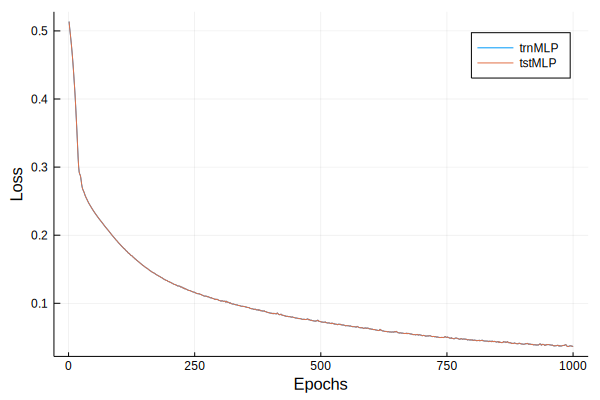

In [120]:
plot([r1[1,:], r1[2,:]],
     labels=[:trnMLP :tstMLP],xlabel="Epochs",ylabel="Loss")

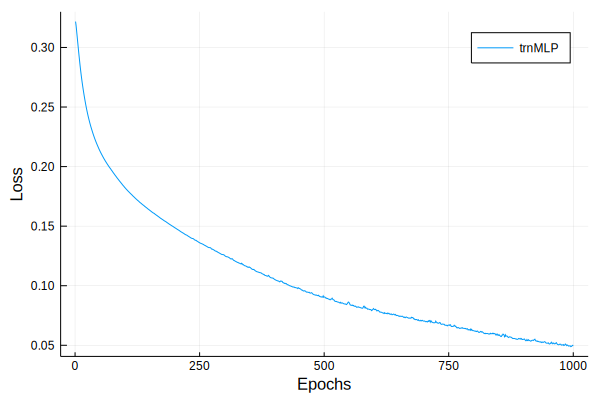

In [115]:
plot([r1[2,:]],
     labels=[:trnMLP :tstMLP],xlabel="Epochs",ylabel="Loss")